In [1]:
import pymc3 as pm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 6.1 オッカムのカミソリー単純さと精度

### コード6.1 ４種類の多項式によりフィッティングを行い、決定係数を出力する

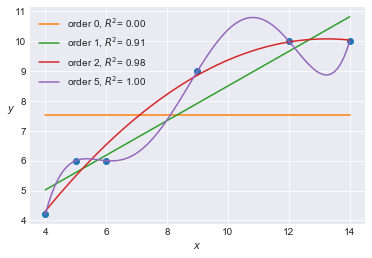

In [2]:
x = np.array([4.0, 5.0, 6.0, 9.0, 12.0, 14.0])
y = np.array([4.2, 6.0, 6.0, 9.0, 10.0, 10.0])

order = [0, 1, 2, 5]
plt.plot(x, y, 'o')

for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat - ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = ssreg / sstot
    
    plt.plot(x_n, ffit, label='order {}, $R^2$= {:.2f}'.format(i, r2))
    
plt.legend(loc=2)
plt.xlabel('$x$')
plt.ylabel('$y$', rotation=0)

## 6.2 事前分布の正則化

### コード6.2 ４種類のラプラス分布と正規分布を出力する

(-7, 7)

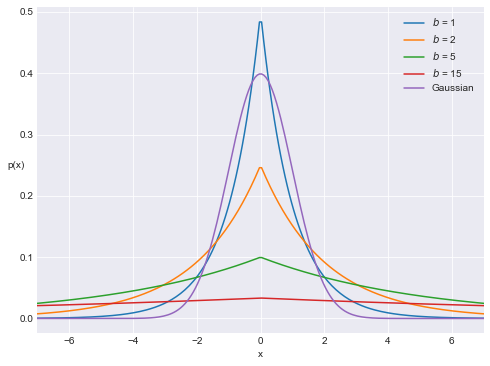

In [3]:
plt.figure(figsize=(8,6))
x_values = np.linspace(-10, 10, 300)
for df in [1, 2, 5, 15]:
    distri = stats.laplace(scale=df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label='$b$ = {}'.format(df))
    
x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label='Gaussian')
plt.xlabel('x')
plt.ylabel('p(x)', rotation=0)
plt.legend(loc=0)
plt.xlim(-7, 7)

### コード6.3 情報量規準を例示するためのデータを出力する

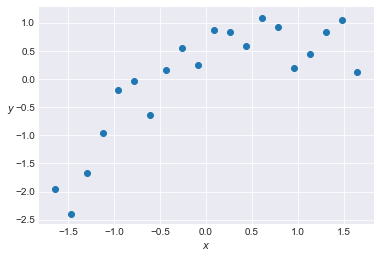

In [8]:
real_alpha = 4.25
real_beta = [8.7, -1.2]
data_size = 20
noise = np.random.normal(0, 2, size=data_size)
x_1 = np.linspace(0, 5, data_size)
y_1 = real_alpha + real_beta[0] * x_1 + real_beta[1] * x_1**2 + noise

order = 2 # 5
x_1p = np.vstack([x_1 ** i for i in range(1, order + 1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()

plt.scatter(x_1s[0], y_1s)
plt.xlabel('$x$')
plt.ylabel('$y$', rotation=0)

### コード6.4 情報量規準を例示するために線形回帰モデルと２次の多項式モデルを出力する

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 2 chains: 100%|██████████| 5200/5200 [00:04<00:00, 1191.25draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f7a7898>,
      dtype=object)

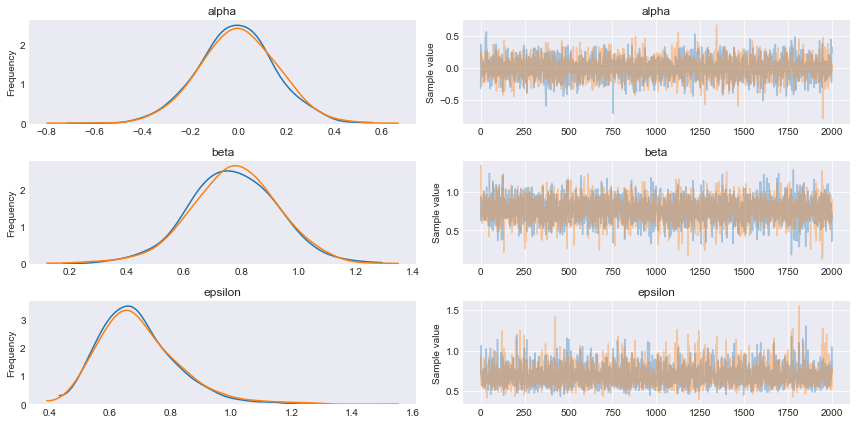

In [9]:
# 線形回帰モデル
with pm.Model() as model_l:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = alpha + beta * x_1s[0]
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_1s)
    
    trace_l = pm.sample(2100)
    
chain_l = trace_l[100:]
pm.traceplot(chain_l)

In [10]:
pm.summary(chain_l)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-0.006499,0.160140,0.002971,-0.312472,0.312000,3055.311599,1.000409
beta,0.770298,0.154822,0.002192,0.474561,1.091834,4615.339543,0.999889
epsilon,0.694256,0.129788,0.002265,0.478674,0.952627,2897.894044,1.000837


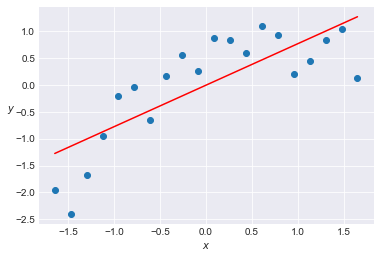

In [12]:
y_p = chain_l['alpha'].mean() + chain_l['beta'].mean() * x_1s[0]

plt.scatter(x_1s[0], y_1s)
plt.plot(x_1s[0], y_p, color='r')
plt.xlabel('$x$')
plt.ylabel('$y$', rotation=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 2 chains:  93%|█████████▎| 4856/5200 [00:09<00:00, 505.43draws/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
Sampling 2 chains: 100%|██████████| 5200/5200 [00:11<00:00, 464.55draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12140ffd0>,
      dtype=object)

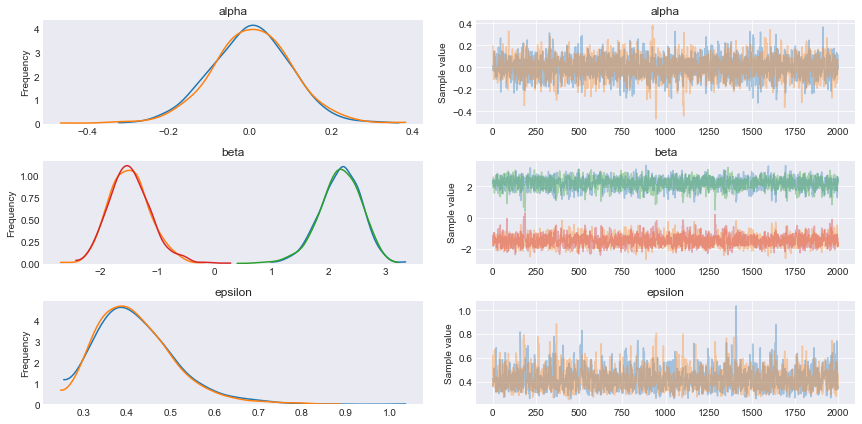

In [14]:
# 多項式モデル
with pm.Model()  as model_p:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=x_1s.shape[0])
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = alpha + pm.math.dot(beta, x_1s)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_1s)
    
    trace_p = pm.sample(2100)
    
chain_p = trace_p[100:]
pm.traceplot(chain_p)

In [15]:
pm.summary(chain_p)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.001887,0.098439,0.001762,-0.197019,0.188477,2315.472704,0.999908
beta__0,2.199897,0.370214,0.009745,1.483554,2.920207,1299.991942,1.000138
beta__1,-1.479397,0.368179,0.009767,-2.182036,-0.746181,1289.458854,1.000366
epsilon,0.420663,0.090143,0.002337,0.267020,0.593096,1315.359301,0.999962


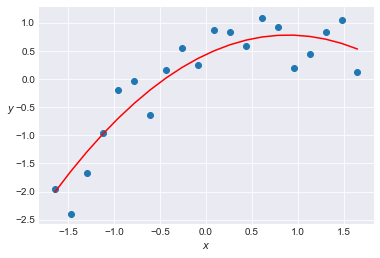

In [22]:
y_p = chain_p['alpha'].mean() + np.dot(x_1s.T, chain_p['beta'].mean(axis=0, keepdims=True).T)

plt.scatter(x_1s[0], y_1s)
plt.plot(x_1s[0], y_p, color='r')
plt.xlabel('$x$')
plt.ylabel('$y$', rotation=0)

In [24]:
# WAICとLOOを表示する
pm.waic(trace=trace_l, model=model_l)

/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=43.65439837631966, WAIC_se=5.205432023699242, p_WAIC=2.6822750837201936, var_warn=1)

In [25]:
pm.waic(trace=trace_p, model=model_p)

/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=24.552097790803273, WAIC_se=4.721710905871386, p_WAIC=3.4718842802881236, var_warn=1)

### コード6.9 線形単回帰モデルと2次多項式モデルの事後予測をチェックする

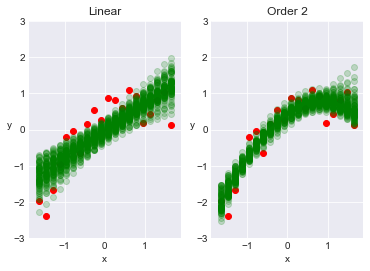

In [30]:
plt.subplot(121)
plt.scatter(x_1s[0], y_1s, c='r')
plt.ylim(-3,3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Linear')
for i in range(0, len(chain_l['alpha']), 50):
    plt.scatter(x_1s[0], chain_l['alpha'][i] + chain_l['beta'][i]*x_1s[0], c='g', edgecolors='g', alpha=0.2)
plt.plot(x_1s[0], chain_l['alpha'].mean() + chain_l['beta'].mean() * x_1s[0], c='g', alpha=1)

plt.subplot(122)
plt.scatter(x_1s[0], y_1s, c='r')
plt.ylim(-3,3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Order {}'.format(order))

for i in range(0, len(chain_l['alpha']), 50):
    plt.scatter(x_1s[0], chain_p['alpha'][i] + np.dot(chain_p['beta'][i], x_1s), c='g', edgecolors='g', alpha=0.2)
idx = np.argsort(x_1)
plt.plot(x_1s[0][idx], y_p[idx], c='g', alpha=1)

## 6.4 ベイズファクター

### コード6.10 ベイズファクターを例示するためのモデルを出力する

In [31]:
coins = 30
heads = 9
y_d = np.repeat([0, 1], [coins-heads, heads])

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [theta]
>BinaryGibbsMetropolis: [model_index]
100%|██████████| 6000/6000 [00:06<00:00, 896.92it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12245fc18>,
      dtype=object)

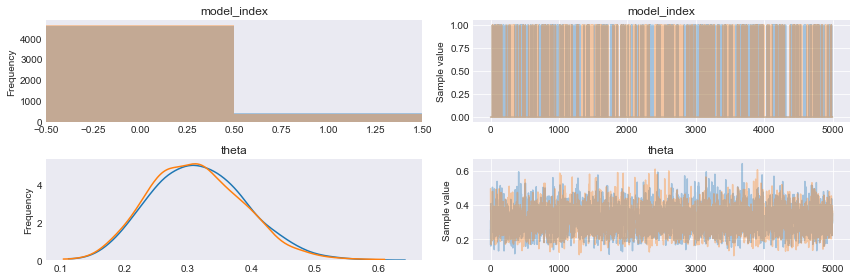

In [33]:
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)
    m_0 = (4, 8)
    m_1 = (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)
    
    theta = pm.Beta('theta', m[0], m[1])
    y = pm.Bernoulli('y', theta, observed=y_d)
    trace_BF = pm.sample(5500, njobs=1)
    
chain_BF = trace_BF[500:]
pm.traceplot(chian_BF)

In [36]:
pM1 = chain_BF['model_index'].mean()
pM0 = 1 - pM1
BF = (pM0 / pM1)*(p[1]/p[0])
print(pM0, pM1, BF)

0.9208 0.0792 11.626262626262625
